In [8]:
# import data

import pandas as pd

# training data
train = pd.read_csv("occupancy_data/datatraining.txt")
x_train = train.ix[:,1:6]
y_train = train.ix[:, 6]

# testing data
test = pd.read_csv("occupancy_data/datatest.txt")
x_test = test.ix[:,1:6]
y_test = test.ix[:, 6]

# testing data2
test2 = pd.read_csv("occupancy_data/datatest2.txt")
x_test2 = test2.ix[:,1:6]
y_test2 = test2.ix[:, 6]

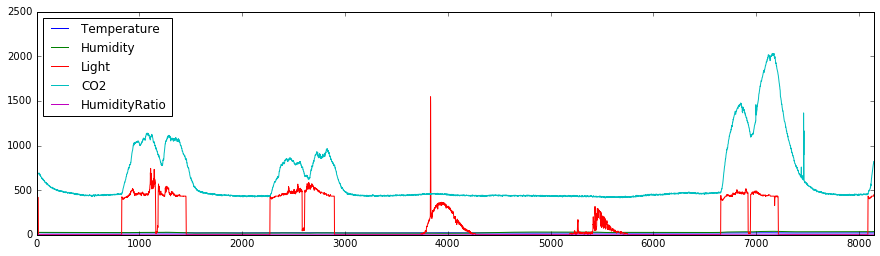

In [10]:
%matplotlib inline

# visualize data

import matplotlib as plt
plt.rcParams['figure.figsize'] = (15, 4)

x_train.plot()

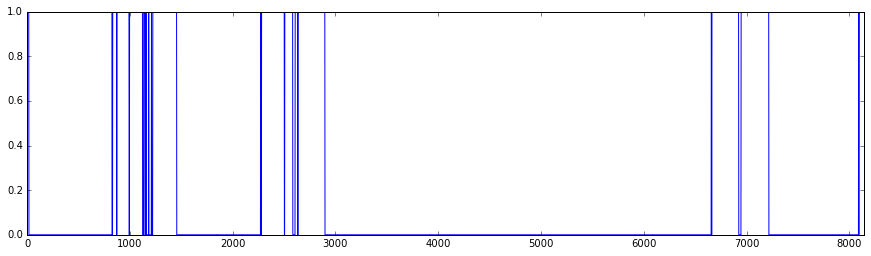

In [11]:
y_train.plot()

In [12]:
# regularize the data

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

# transform training data
scaler.fit(x_train)
x_train_transform = pd.DataFrame( scaler.fit_transform(x_train ))


# transform testing data
x_test_transform = pd.DataFrame( scaler.transform(x_test ))
x_test2_transform = pd.DataFrame( scaler.transform(x_test2 ))

In [119]:
## train MLP with GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import GridSearchCV

hidden_layer_sizes = [
    (4, 4, 4, 2),
    (5, 5, 5, 2),
    (4, 4, 4, 2)
]

model = MLPClassifier(solver='lbfgs', 
                      alpha=1e-5, 
                      random_state=1)

grid = GridSearchCV(estimator  = model,
                    param_grid = dict(hidden_layer_sizes=hidden_layer_sizes),
                    cv = 5, 
                    verbose = 1,
                    n_jobs = 2)

grid.fit(x_train_transform, y_train)

print(grid)
print(grid.best_score_)
print(grid.best_estimator_.hidden_layer_sizes)
#clf.fit(x_train_transform, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:    8.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'hidden_layer_sizes': [(4, 4, 4, 2), (5, 5, 5, 2), (4, 4, 4, 2)]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)
0.950878054770969
(5, 5, 5, 2)


In [153]:
## train MLP with scipy.optimize
import numpy as np
from scipy.optimize import basinhopping
from sklearn.model_selection import cross_val_score

# define training function with score output
def train_mlp(net_width):
    net_width = int(np.round( net_width )) - 4
    
    model = MLPClassifier(solver='lbfgs', 
                      alpha=1e-5, 
                      random_state=1,
                      hidden_layer_sizes = (net_width, net_width, net_width, 2))
    #model.fit(x_train_transform, y_train)
    scores = cross_val_score(model, x_train_transform, y_train, n_jobs=1, verbose=0)
    return 1 - np.mean(scores)

In [152]:
## TODO: make scipy-wrapper work

def callbackF(x, f, accept):
    print("x: " + str(x))
    print("f: " + str(f))
    print("accept: " + str(accept))
    print()

x0 = np.array(5)
bounds = np.array([2, 12])
res = basinhopping(train_mlp, x0, niter=3,
               callback=callbackF)

x: [ 4.88448136]
f: 0.212329584498
accept: True

x: [ 5.27188515]
f: 0.212329584498
accept: True

x: [ 5.02047336]
f: 0.212329584498
accept: True



In [133]:
train_mlp(5)

[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.8s finished


0.054400705290108431

In [89]:
res.x

array(7.61803065717419)

In [183]:
# prediction (positives)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_predict  = pd.DataFrame( grid.predict( x_test_transform  ))
y_predict2 = pd.DataFrame( grid.predict( x_test2_transform ))

print("Test set 1:")
print(confusion_matrix(y_test,  y_predict))
print("precision: ", precision_score(y_test, y_predict))
print("recall: ", recall_score(y_test, y_predict))
print()

print("Test set 2:")
print(confusion_matrix(y_test2, y_predict2))
print("precision: ", precision_score(y_test2, y_predict2))
print("recall: ", recall_score(y_test2, y_predict2))

Test set 1:
[[1634   59]
 [   4  968]]
precision:  0.942551119766
recall:  0.995884773663

Test set 2:
[[7148  555]
 [ 217 1832]]
precision:  0.767490573942
recall:  0.894094680332
